# Monte Carlo Assignment
## The Stokes Flow

##### Laurent Pétré & Ilan Renous

In this assignment, we are going to generate random numbers with different distributions, simulate a brownian motion and simulate a model that predicts magnetism in a ferromagnetic material.

In [39]:
#we import libraries
import numpy
from matplotlib import pyplot
%matplotlib inline

## Random numbers

### Built-in Vs DIY Implementations

We are going to generate random numbers following a gaussian and an exponential distibution from a uniform random numbers generator. For the Gaussian distibution we are going to use the Von-Neumann rejection method and compare it to the built in numpy metod.

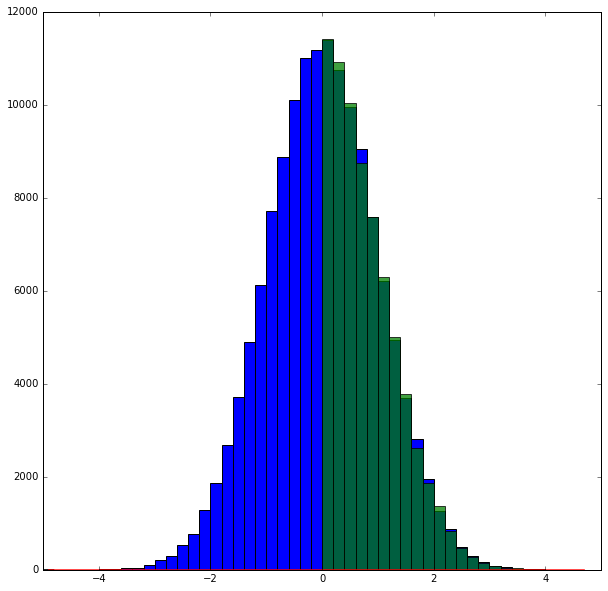

In [40]:
# Number of random numbers to draw according to p1 
N = 100000
K = 1.4

# Empty list for the final set of numbers
h=[]

#given Gaussian generator from the course with VNR method
for i in range(N):
    u1 = numpy.random.random_sample()
    
    # Distribute g according to the exponential distribution
    g = numpy.log(1/(1-u1))
    
    # Generate a second number for the acceptance/rejection condition
    u2 = numpy.random.random_sample()
    
    # Acceptance/rejection step
    ratio = 2*numpy.exp(-g**2/2.0)/numpy.sqrt(2*numpy.pi) / \
                (K*numpy.exp(-g))
    if (u2<ratio):
        # Append g to the set h
        h.append(g)

# Built-in generator; we generate twice as much number as with the VNRM to have
#to have a scaled histogram 
x = numpy.random.normal(loc=0, scale=1, size=2*len(h))

# Plot
pyplot.figure(figsize=(10,10))
pyplot.xlim(-5, 5)

binwidth = 0.2
bins = numpy.arange(-5, 5, binwidth)
pyplot.hist(x, bins, normed=False)
pyplot.hist(h, bins, normed=False, alpha=0.75)

#Expected
bin_centers = bins[:-1] + binwidth/2
pyplot.plot(bin_centers, numpy.exp(-bin_centers**2/2.0)/numpy.sqrt(2*numpy.pi))

We see that the two distribution give very similar random number distribution.

For the exponential distribution, we use the inverse function method.

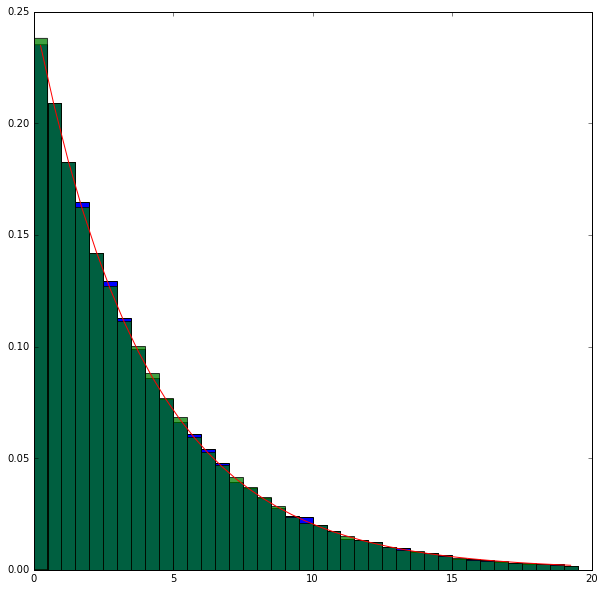

In [41]:
alpha = 0.25 # Rate of the exponential distribution

# Built-in generator
x = numpy.random.exponential(scale=1/alpha, size=100000)

# Inverse function
u = numpy.random.random_sample(100000)
y = -1/alpha*numpy.log(1-u)

# Plot
pyplot.figure(figsize=(10,10))
pyplot.xlim(0, 20)

binwidth = 0.5
bins = numpy.arange(0, 20, binwidth)
pyplot.hist(y, bins, normed=True);
pyplot.hist(x, bins, normed=True, alpha=0.75);

#Expected
bin_centers = bins[:-1] + binwidth/2
pyplot.plot(bin_centers, alpha*numpy.exp(-alpha*bin_centers))

Once again, we can see that the random numbers genreated by the inversion method are really close to those generated by the built in generator.

### Box-Muller

Now, we are going to use another method to generate a gaussian distribution: the Box-Muller method.

This method is summurized as follow:

We use the product of two independant gaussian distributions  
$$
f(x, y)=\frac{1}{2\pi} e^{-\frac{x^2+y^2}{2}}
$$

We consider the polar coordinates

$$x=r\cos(\theta)$$
$$y=r\sin(\theta)$$

From the central symmetry, $\theta$ is of course uniformly distribited in the interval $[0,2\pi[$. With this fact, we can conclude that $r$ is distibuted following the relation:
$$r=\sqrt{-2\ln{u}}$$

Where u is a uniformly distributed variable in the interval $[0,1[$.
For our implementation, we use the

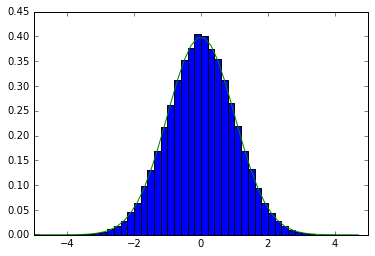

In [42]:
def gauss(avg, stdev):
    # Implémentation de la méthode Box-Muller polaire
    # Cette forme est plus rapide et plus précise autour des 0 des nombres aléatoires

    s = 2.0
    while ( (s == 0) or ( s>=1 ) ):
            i = numpy.random.random_sample(2)
            i[:] = i[:]*2 - 1
            s = sum(i*i)

    return avg + stdev * i[:]*numpy.sqrt((-2*numpy.log(s))/s)

x = numpy.empty(100000)
for i in range(0, 50000):
    t = gauss(0, 1)
    x[i] = t[0]
    x[50000 + i] = t[1]

# Plot
pyplot.xlim(-5, 5)

binwidth = 0.2
bins = numpy.arange(-5, 5, binwidth)
pyplot.hist(x, bins, normed=True);

#Expected
bin_centers = bins[:-1] + binwidth/2
pyplot.plot(bin_centers, numpy.exp(-bin_centers**2/2.0)/numpy.sqrt(2*numpy.pi))

This method is very efficient and generate, like we can see on this graph, random numbers following a gaussian distribution.

## Brownian motion

The model equation for the evolution of the position of a molecule of dye in water is:

$$
dx=x(t+dt)−x(t)=ds
$$

$ds$ is a displacement resulting from the collision with surrounding water molecules.

We will model $ds$ as
$$ ds=cdt+\alpha \sqrt{dt}\cal{N(0,1)} $$

where $\alpha$ is the same diffusion coefficient that one would use in the diffusion equation. Moreover, at each time step, $\cal{N(0,1)}$ is a random number that is generated from a normal  distribution $f(n)$, centered around $0$, and with variance equal to $1$. 

This is a deplacement forced by a rondom collision and by a systematic displacment $cdt$. This could model an electrons under a electric field "colliding" randomly with atoms in a metal.

We will follow the path of 100000 particules that are subject to this motion during a time  $T$. At time $t=0$ the positions of the particules are chosen to follow a gaussian distribution. let's see whats does the position distribution looks like at time $T$.

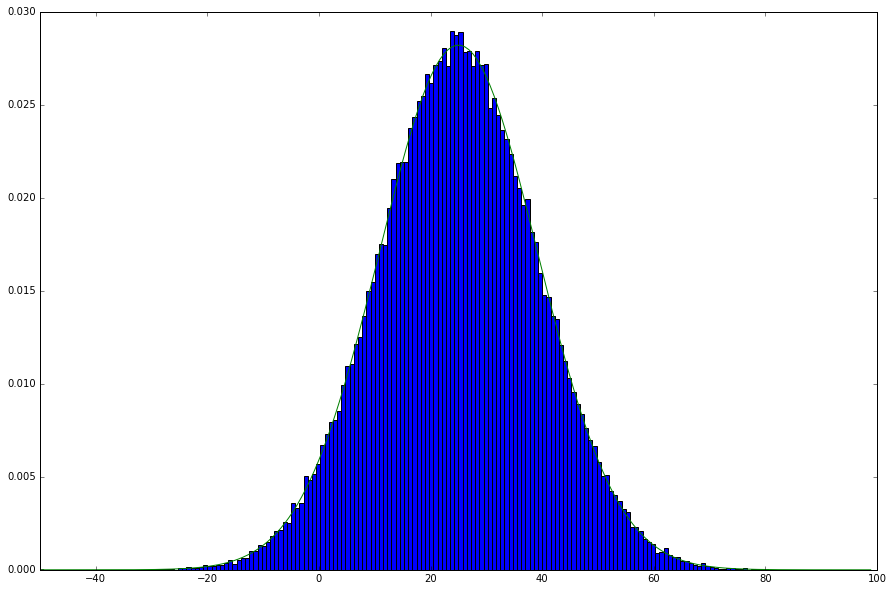

In [43]:
npart = 100000

T = 50.0
nt = 500
dt = T/nt

alpha = 2.0
c = 0.5

# Generate a set of initial positions based on the Gaussian distribution
x = numpy.random.normal(loc=0,scale=1,size=npart)

# Evolution
for i in range(nt):
    xi = x.copy()
    x = xi + c*dt + alpha*numpy.sqrt(dt)*numpy.random.normal(0, 1, npart)

# Plot
pyplot.figure(figsize=(15, 10))
pyplot.xlim(-50, 100)

binwidth = 0.75
bins = numpy.arange(-50, 100, binwidth)
pyplot.hist(x, bins, normed=True);

#Expected
bin_centers = bins[:-1] + binwidth/2
pyplot.plot(bin_centers, numpy.exp(-(bin_centers - c*T)**2/(2.0*alpha**2*T)) \
                            / numpy.sqrt(2*numpy.pi*alpha**2*T))

The particles tend to spread away from each other and are "pushed" towards increasing x.

### Friction

We can model the displacment $ds$ by 
$$ ds=-\gamma x dt +\alpha \sqrt{dt}\cal{N(0,1)} $$

this can be a model for a deplacement forced by a rondom collision with a friction term. We will analize the positions of the particules after a time $T$ with the same initial setup as before.

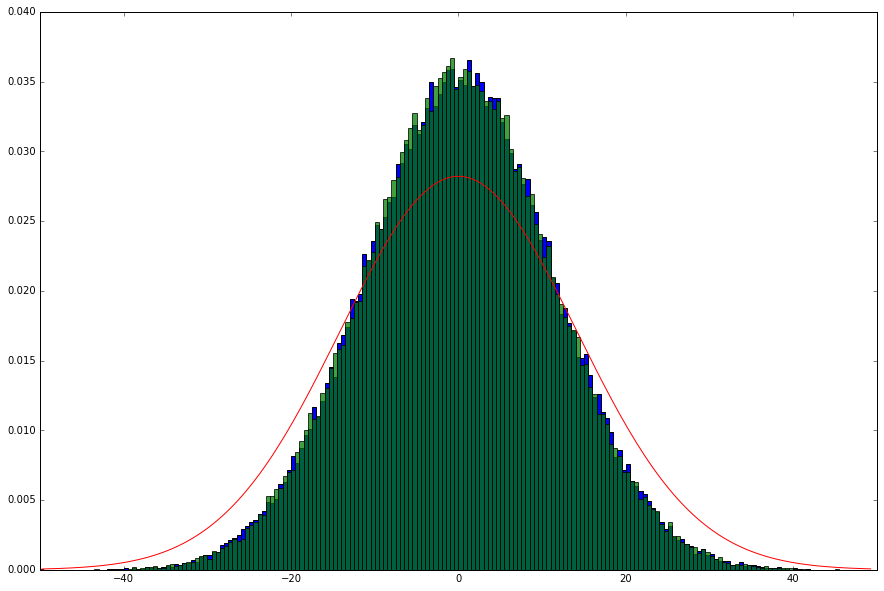

In [44]:
npart = 100000

T1 = 15000
T2=20000
nt = 5000
dt = T/nt
def friction(T,nt,dt):
    alpha = 2.0
    gamma = 0.01

    # Generate a set of initial positions based on the Gaussian distribution
    x = numpy.random.normal(loc=0, scale=1, size=npart)

    # Evolution
    for i in range(nt):
        xi = x.copy()
        x = xi - gamma*xi*dt + alpha*numpy.sqrt(dt)*numpy.random.normal(0, 1, npart)
    return x
x1=friction(T1,nt,dt)
x2=friction(T2,nt,dt)
# Plot
pyplot.figure(figsize=(15, 10))
pyplot.xlim(-50, 50)

binwidth = 0.5
bins = numpy.arange(-50, 50, binwidth)
pyplot.hist(x1, bins, normed=True);
pyplot.hist(x2, bins, normed=True,alpha=0.75)
#Expected
bin_centers = bins[:-1] + binwidth/2
pyplot.plot(bin_centers, numpy.exp(-(bin_centers)**2/(2.0*alpha**2*T)) \
                             / numpy.sqrt(2*numpy.pi*alpha**2*T))
 

Here, we compare two distributions at very large time $T1$ and $T2$. We can see that they are really close. We can suppose that the distribution reaches a steady states as $t\rightarrow \infty$. This can be checked anatically:

## Ising model

### Functions definition

In [49]:
def energy_array(sp, alpha):
    return -alpha*sp[:, :]* \
        (numpy.roll(sp, 1, axis=0) + numpy.roll(sp, -1, axis=0) + \
         numpy.roll(sp, 1, axis=1) + numpy.roll(sp, -1, axis=1))

def total_energy(sp, alpha):
    return energy_array(sp, alpha).sum()

In [50]:
def total_magnetization(sp):
    return sp.sum()

In [51]:
def energy_at_site(sp,alpha,sigma,ix,iy):
    """ Computes the contribution to the energy for a given spin
    at location ix,iy for a lattice with periodic boundary conditions
   
    Parameters:
    ----------
    sp: numpy array
        array of spins
    alpha  : real
        coupling constant J/(kb*T)
    sigma   : int
        spin at site ix,iy
    ix   : int
        location in x
    iy   : int
        location in y
    
   
    Returns:
    -------
    energy: energy for the given configuration
    """
    
    energy=-alpha*sigma*(sp[(ix-1)%nx,iy]+sp[(ix+1)%nx,iy]+sp[ix,(iy-1)%ny]+sp[ix,(iy+1)%ny])

    return energy


In [52]:
def metropolis_at_site(sp,alpha,ix,iy):
    """ Flips a dipole at site ix, iy when probability condition is met 
   
    Parameters:
    ----------
    sp: numpy array
        array of spins
    alpha  : real
        coupling constant J/(kb*T)
    ix   : int
        location in x
    iy   : int
        location in y
    """
    sigma=sp[ix,iy]
    energy_before_flip = energy_at_site(sp,alpha,sigma,ix,iy)
    sigma = -sigma
    energy_if_site_flipped = energy_at_site(sp,alpha,sigma,ix,iy)
    
    # Flip the site with Metropolis probability
    # Condition is always satisifed if dE < 0
    if (numpy.random.random_sample()<numpy.exp(-(energy_if_site_flipped \
                                               -energy_before_flip))):
        sp[ix,iy]=-sp[ix,iy]

def ising_model_metropolis(sp, NMC, nx, ny, alpha):
    """ Creates a sequence of states for the Ising model using
    the Metropolis algorithm
   
    Parameters:
    ----------
    sp   : initial lattice state
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
    NMC  : int
        Number of states to create
    alpha  : real
        coupling constant J/(kb*T)
    Returns:
    -------
    states: sequence of states
    """
    states = numpy.empty([NMC+1,nx,ny])
    states[0] = sp.copy()
    
    for i in range(1,NMC+1):
        for j in range(0,nx*ny):
            ix=numpy.random.random_integers(0,nx-1)
            iy=numpy.random.random_integers(0,ny-1)
            metropolis_at_site(sp,alpha,ix,iy)
        states[i]=sp.copy()
    return states

In [53]:
NMC = 100

nx = 100
ny = 100

na = 20

alpha = numpy.linspace(0.25, 0.55, na)
#alpha = [0.1, 0.2, 0.3, 0.35, 0.37, 0.39, 0.41, 0.43, 0.45, 0.5, 0.6, 0.7]
energy = numpy.zeros(na)
magn = numpy.zeros(na)

for i in range(0, na):
    sp = numpy.ones([nx,ny])
    states = ising_model_metropolis(sp, NMC, nx, ny, alpha[i])
    for j in range(0, NMC+1):
        energy[i] += total_energy(states[j], alpha[i])/(NMC+1)
        magn[i] += total_magnetization(states[j])/(NMC+1)

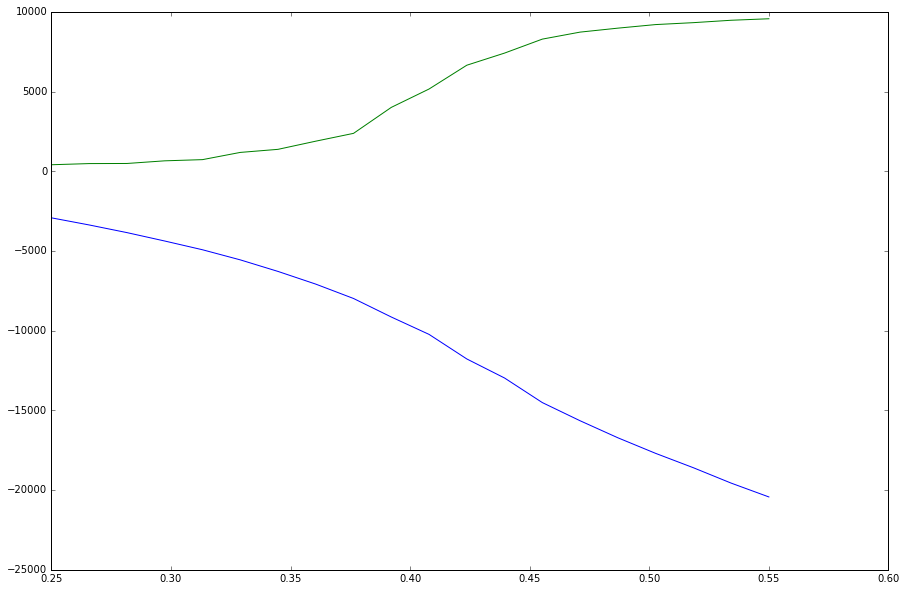

In [54]:
pyplot.figure(figsize=(15, 10))
pyplot.plot(alpha, energy)
pyplot.plot(alpha, magn)